In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-08-16 07:00:04.215898: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-16 07:00:04.246751: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 07:00:04.702504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Coletando dados

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/Sciaenidae/RJ_Reconstrucao_Sciaenidae_2024_08_06.xlsx')

df_Pesc_bicuda = pd.DataFrame(df[['Ano','Pesc_bicuda_art','Pesc_bicuda_ind','Pesc_bicuda_art_ind']])

#Somando art e ind em art_ind
for i in range(len(df_Pesc_bicuda['Ano'])):
  if pd.isnull(df_Pesc_bicuda.iloc[i,3])==True and pd.isnull(df_Pesc_bicuda.iloc[i,2])==False and pd.isnull(df_Pesc_bicuda.iloc[i,1])==False:
    df_Pesc_bicuda.iloc[i,3] = df_Pesc_bicuda.iloc[i,2] + df_Pesc_bicuda.iloc[i,1] 


dados = df_Pesc_bicuda[['Ano','Pesc_bicuda_art','Pesc_bicuda_art_ind']].dropna().reset_index(drop=True)

#Fazendo as proporções
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_Pesc_bicuda_art'] = dados.loc[i,'Pesc_bicuda_art'] / dados.loc[i,'Pesc_bicuda_art_ind']


anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1976,1977])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()



prop = dados['Prop_Pesc_bicuda_art'].values

dados.head()

,Ano,Pesc_bicuda_art,Pesc_bicuda_art_ind,Prop_Pesc_bicuda_art
0,2010,0.3000,0.9150,0.327869
1,2014,1.8520,1.8930,0.978341
2,2018,0.1881,0.3881,0.484669
3,2019,0.1343,0.5533,0.242725
4,2021,0.0150,0.1420,0.105634


In [3]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [4]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,prop_norm, epochs=33, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/Sciaenidae/Pesc_bicuda/pesos prop art/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/Sciaenidae/Pesc_bicuda/pesos prop art/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Previsões dos dados ausentes: [[0.35559666]
 [0.35853085]]


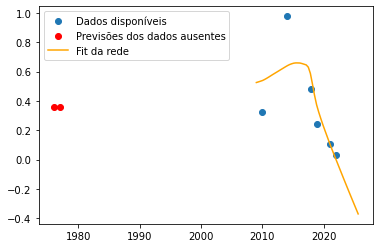

In [6]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

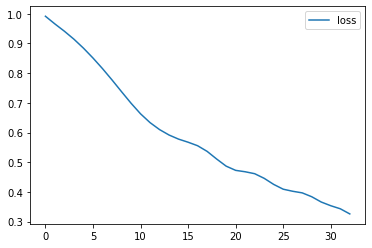

In [25]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [7]:
#Lista de anos sem buracos normalizada e sua predição      (para poder me referir por indices)

anos = np.arange(1950,np.max(anos_para_prever)+1)
anos_norm = (anos-ano_mean)/ano_std
prev_continua = model.predict(anos_norm)*prop_std + prop_mean

for i in range(len(prev_continua)):
    if prev_continua[i]<0:
        prev_continua[i]=0
    if prev_continua[i]>=1:
        prev_continua[i]=1


df_preenchido = df[['Ano','Pesc_bicuda_art']]
for i in range(len(prev_continua)):
    if i+1950 in anos_para_prever:
      df_preenchido.loc[i,'Pesc_bicuda_art']=df.loc[i,'Pesc_bicuda_art_ind']*prev_continua[i]


with pd.option_context('display.max_rows', None,):
    print(df_preenchido)


#Planilha com os dados preenchidos
df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/Sciaenidae/Pesc_bicuda/Previsão Pesc_bicuda_art_1976-1977.xlsx')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     Ano  Pesc_bicuda_art
0   1950              NaN
1   1951              NaN
2   1952              NaN
3   1953              NaN
4   1954              NaN
5   1955              NaN
6   1956              NaN
7   1957              NaN
8   1958              NaN
9   1959              NaN
10  1960              NaN
11  1961              NaN
12  1962              NaN
13  1963              NaN
14  1964              NaN
15  1965              NaN
16  1966              NaN
17  1967              NaN
18  1968              NaN
19  1969              NaN
20  1970              NaN
21  1971              NaN
22  1972              NaN
23  1973              NaN
24  1974              NaN
25  1975              NaN
26  1976         3.555967
27  1977         5.019433
28  1978         1.000000
29  1979              NaN
30  1980              NaN
31  1981              NaN
32  1982              NaN
33  1983              NaN
34  1984              NaN
35  1985              NaN


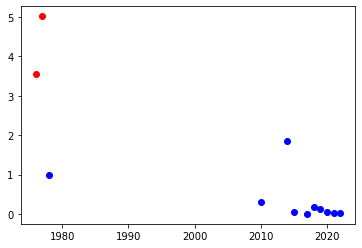

In [8]:
for i in range(len(df_preenchido['Ano'])):
  if i+1950 in anos_para_prever:
    plt.scatter(df_preenchido['Ano'].values[i],df_preenchido['Pesc_bicuda_art'].values[i],color='red')
  else:
    plt.scatter(df_preenchido['Ano'].values[i],df_preenchido['Pesc_bicuda_art'].values[i],color='blue')